In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
# Load the data frames
registration = pd.read_csv('./data/Registration.txt', sep='|', encoding_errors='replace', on_bad_lines='skip')
owner_op = pd.read_csv('./data/Owner_Operator.txt', sep='|', encoding_errors='replace', on_bad_lines='skip')
reg_imp = pd.read_csv('./data/Reg_Imp_ID_by_Manu.txt', sep='|', encoding_errors='replace', on_bad_lines='skip')
listing_pcd = pd.read_csv('./data/Listing_PCD.txt', sep='|', encoding_errors='replace', on_bad_lines='skip')
foiclass = pd.read_csv('./data/foiclass.txt', sep='|', encoding_errors='replace', on_bad_lines='skip')

In [3]:
# Helper Function to print categorical stats
def printCategoricalInfo(df, columns):
    # Print the number of unique values and the highest frequecies for
    # (pseudo)categorical variables
    for col in columns:
        print(f"{col:=^78}")
        print()
        print("Number of unique values:", df[col].unique().shape[0])
        print(df[col].unique())
        print()
        print("Top 5 Highest Frequencies:")
        print(df[col].value_counts().head(5))
        print()
    

## Registration 
Revelant Columns:
* REG_KEY
* NAME
* CITY
* STATE_ID
* ISO_COUNTRY_CODE

### Data Description

In [4]:
# get the dimensions of the registration
registration.shape

(46493, 15)

In [5]:
# Columns in registration
registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46493 entries, 0 to 46492
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   REG_KEY                46493 non-null  int64  
 1   REGISTRATION_NUMBER    46077 non-null  float64
 2   FEI_NUMBER             46077 non-null  float64
 3   REG_STATUS_ID          46493 non-null  int64  
 4   INITIAL_IMPORTER_FLAG  46493 non-null  object 
 5   REG_EXPIRY_DATE_YEAR   46493 non-null  int64  
 6   ADDRESS_TYPE_ID        46493 non-null  object 
 7   NAME                   46491 non-null  object 
 8   ADDRESS_LINE_1         46491 non-null  object 
 9   ADDRESS_LINE_2         10832 non-null  object 
 10  CITY                   46491 non-null  object 
 11  STATE_ID               30243 non-null  object 
 12  ISO_COUNTRY_CODE       46493 non-null  object 
 13  ZIP_CODE               30248 non-null  float64
 14  POSTAL_CODE            16197 non-null  object 
dtypes:

In [6]:
# REG_KEY: Numeric Identifier: Range of IDs
registration.REG_KEY.agg(['min', 'max'])

min         5
max    331290
Name: REG_KEY, dtype: int64

In [7]:
# Get the relevant columns
registration_columns = [
    "REG_KEY",
    "NAME",
    "CITY",
    "STATE_ID",
    "ISO_COUNTRY_CODE"
]

# Print the number of unique values and the highest frequecies for
# (pseudo)categorical variables
printCategoricalInfo(registration, registration_columns)


===================================REG_KEY====================================

Number of unique values: 30252
[  7542   7578   6813 ... 330364 330554 330340]

Top 5 Highest Frequencies:
REG_KEY
7542      2
328659    2
328568    2
328740    2
328535    2
Name: count, dtype: int64

=====================================NAME=====================================

Number of unique values: 34743
['DEGUDENT GMBH' 'Dan Eagar' 'PALL NEWQUAY' ... 'BSD PRODUCT DESIGN INC.'
 'Vernon Area Rehabilitation Center, Inc. - Racine Division'
 'SYS-MAC AUTOMATION ENGINEERING PTE LTD']

Top 5 Highest Frequencies:
NAME
David Lennarz    1297
Leeyeo Kee        736
Greg Swanson      311
Jerry Doane       210
Charles Mack      172
Name: count, dtype: int64

=====================================CITY=====================================

Number of unique values: 11537
['HANAU Hesse' 'Charlotte' 'Newquay Cornwall' ... 'Kalaheo' 'barcarena'
 'Brookings']

Top 5 Highest Frequencies:
CITY
Hampton               1294
Do

### Data Wrangling

In [8]:
# Keep the relevant columns only
registration_subset = registration[registration_columns]
registration_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46493 entries, 0 to 46492
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   REG_KEY           46493 non-null  int64 
 1   NAME              46491 non-null  object
 2   CITY              46491 non-null  object
 3   STATE_ID          30243 non-null  object
 4   ISO_COUNTRY_CODE  46493 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [9]:
# Drop data missing city and name
registration_subset = registration_subset.dropna(subset=['NAME', 'CITY'])

Remove duplicated entries from Registration.

Registrations outside of the US have two registrations with the same REG_KEY: one outside the US and a US contact. For conveinence, we remove the US reference to see where the registration is actually located. 


In [10]:
# Condition: keep only the rows where the REG_KEY is either not duplicated at all, or is duplicated and is not registered in the US
cond = (~registration_subset.REG_KEY.duplicated(keep=False)) | (registration_subset.ISO_COUNTRY_CODE != 'US')

# Get rows (boolean indexing)
registration_cleaned = registration_subset[cond]

## Owner Operator 
Revelant Columns:
* REG_KEY
* FIRM_NAME
* OWNER_OPERATOR_NUMBER

### Data Description

In [11]:
# get the dimensions of the registration
owner_op.shape

(30254, 4)

In [12]:
# Columns in registration
owner_op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30254 entries, 0 to 30253
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   REG_KEY                30254 non-null  int64 
 1   CONTACT_ID             30254 non-null  int64 
 2   FIRM_NAME              30254 non-null  object
 3   OWNER_OPERATOR_NUMBER  30254 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 945.6+ KB


In [13]:
# REG_KEY: Numeric Identifier: Range of IDs
owner_op.REG_KEY.agg(['min', 'max'])

min         5
max    331290
Name: REG_KEY, dtype: int64

In [14]:
# OWNER_OPERATOR_NUMBER: Numeric Identifier: Range of IDs
owner_op.OWNER_OPERATOR_NUMBER.agg(['min', 'max'])

min     1010604
max    10091368
Name: OWNER_OPERATOR_NUMBER, dtype: int64

In [15]:
# Get the relevant columns
owner_op_columns = [
    "REG_KEY",
    "FIRM_NAME",
    "OWNER_OPERATOR_NUMBER"
]

# Print the number of unique values and the highest frequecies for
# (pseudo)categorical variables
printCategoricalInfo(owner_op, owner_op_columns)

===================================REG_KEY====================================

Number of unique values: 30253
[     5      6     16 ... 331285 331288 331290]

Top 5 Highest Frequencies:
REG_KEY
10049     2
5         1
239556    1
239664    1
239652    1
Name: count, dtype: int64

==================================FIRM_NAME===================================

Number of unique values: 25755
['BARNHARDT MFG. CO.' 'CORDIS CORPORATION' 'MEDICAL SPECIALTIES, INC.' ...
 'BioDynamik, Inc' 'Ortho Dental Lab, LLC' 'Medical Feedback Technologies']

Top 5 Highest Frequencies:
FIRM_NAME
STERIS Corporation                          74
Philips Medical Systems International BV    65
STRYKER CORP.                               62
ABBOTT LABORATORIES                         58
Medtronic, Inc.                             55
Name: count, dtype: int64

============================OWNER_OPERATOR_NUMBER=============================

Number of unique values: 25952
[ 1010842  1016427  1016498 ... 10091366 1009

### Data Wrangling

In [16]:
# Keep the relevant columns only
owner_op_subset = owner_op[owner_op_columns]
owner_op_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30254 entries, 0 to 30253
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   REG_KEY                30254 non-null  int64 
 1   FIRM_NAME              30254 non-null  object
 2   OWNER_OPERATOR_NUMBER  30254 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 709.2+ KB


In [17]:
# Check the duplicated rows
ind = owner_op_subset.duplicated(keep=False)
owner_op_subset[ind]

,REG_KEY,FIRM_NAME,OWNER_OPERATOR_NUMBER
778,10049,AMBUTECH INC.,8022025
779,10049,AMBUTECH INC.,8022025


In [18]:
# Remove duplicates
owner_op_cleaned = owner_op_subset.drop_duplicates()

## Registered Importers Identified by Manufacturer
Revelant Columns:
* KEY_VAL
* IMPORTER_REG_KEY
* ESTABLISHMENT_REG_KEY

### Data Description

In [19]:
# get the dimensions of the registration
reg_imp.shape

(235312, 3)

In [20]:
# Columns in registration
reg_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235312 entries, 0 to 235311
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   KEY_VAL                235312 non-null  int64  
 1   IMPORTER_REG_KEY       235312 non-null  int64  
 2   ESTABLISHMENT_REG_KEY  235147 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 5.4 MB


In [21]:
# Print ID ranges for all columns
for col in reg_imp.columns:
    print(reg_imp[col].agg(['min', 'max']))
    print()

min    1000005382
max    2073740917
Name: KEY_VAL, dtype: int64

min         5
max    330712
Name: IMPORTER_REG_KEY, dtype: int64

min        16.0
max    331247.0
Name: ESTABLISHMENT_REG_KEY, dtype: float64



In [22]:
# Print the number of unique values and the highest frequecies for
# (pseudo)categorical variables
printCategoricalInfo(reg_imp, reg_imp.columns)

===================================KEY_VAL====================================

Number of unique values: 107232
[1651424905 1673148225 1103542434 ... 1378881872 1248615711 1829957817]

Top 5 Highest Frequencies:
KEY_VAL
1792369725    448
1408412453    369
1767161457    247
1444641110    247
1639863767    232
Name: count, dtype: int64

===============================IMPORTER_REG_KEY===============================

Number of unique values: 9243
[323855 219886  58743 ...  81710  66289  51998]

Top 5 Highest Frequencies:
IMPORTER_REG_KEY
2339      3848
138812    3361
166279    3297
7737      1701
16731     1635
Name: count, dtype: int64

============================ESTABLISHMENT_REG_KEY=============================

Number of unique values: 10785
[1.60000e+01 5.10000e+01 1.30000e+02 ... 3.31177e+05 3.31247e+05
         nan]

Top 5 Highest Frequencies:
ESTABLISHMENT_REG_KEY
9289.0     3736
41540.0    2847
26624.0    2288
26605.0    2255
43350.0    2018
Name: count, dtype: int64



### Data Wrangling

In [23]:
reg_imp_subset = reg_imp.copy()
reg_imp_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235312 entries, 0 to 235311
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   KEY_VAL                235312 non-null  int64  
 1   IMPORTER_REG_KEY       235312 non-null  int64  
 2   ESTABLISHMENT_REG_KEY  235147 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 5.4 MB


In [24]:
# remove missing values
reg_imp_subset = reg_imp_subset.dropna()

In [25]:
# convert ESTABLISHMENT_REG_KEY to an int
reg_imp_subset.ESTABLISHMENT_REG_KEY = reg_imp_subset.ESTABLISHMENT_REG_KEY.astype('int')

In [26]:
# duplicates exist, remove them
reg_imp_subset.duplicated().sum()

152

In [27]:
# remove duplicates
reg_imp_cleaned = reg_imp_subset.drop_duplicates()

## Listing PCD
Revelant Columns:
* key_val
* PRODUCT_CODE
* CREATED_DATE
* OWNER_OPERATOR_NUMBER

### Data Description

In [28]:
# get the dimensions of the registration
listing_pcd.shape

(316023, 5)

In [29]:
# Columns in registration
listing_pcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316023 entries, 0 to 316022
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   key_val                316023 non-null  int64  
 1   PRODUCT_CODE           316023 non-null  object 
 2   CREATED_DATE           316023 non-null  object 
 3   OWNER_OPERATOR_NUMBER  316023 non-null  int64  
 4   EXEMPT                 0 non-null       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 12.1+ MB


In [30]:
# Print ID ranges for identifer columns
listing_pcd_ranged_columns = [
    'key_val',
    'OWNER_OPERATOR_NUMBER'
]

for col in listing_pcd_ranged_columns:
    print(listing_pcd[col].agg(['min', 'max']))
    print()

min    1000005382
max    2073740917
Name: key_val, dtype: int64

min     1010604
max    10091368
Name: OWNER_OPERATOR_NUMBER, dtype: int64



In [31]:
# Range of dates (use datetime)
dt_converted = pd.to_datetime(listing_pcd.CREATED_DATE, format="%m/%d/%Y")
dt_converted.agg(['min', 'max'])

min   1977-01-15
max   2024-09-09
Name: CREATED_DATE, dtype: datetime64[ns]

In [32]:
listing_pcd_cat_columns = [
    'key_val',
    'PRODUCT_CODE',
    'CREATED_DATE',
    'OWNER_OPERATOR_NUMBER'
]

# Print the number of unique values and the highest frequecies for
# (pseudo)categorical variables
printCategoricalInfo(listing_pcd, listing_pcd_cat_columns)

===================================key_val====================================

Number of unique values: 257718
[1468634297 1718706204 1404748488 ... 2049885007 1389810980 1757856506]

Top 5 Highest Frequencies:
key_val
1585184467    78
1061158106    78
1359997783    76
1276366246    76
1698231490    63
Name: count, dtype: int64

=================================PRODUCT_CODE=================================

Number of unique values: 5506
['EIC' 'ECR' 'EIG' ... 'SBB' 'QHS' 'OLK']

Top 5 Highest Frequencies:
PRODUCT_CODE
HWC    4419
GEI    3322
HRS    3233
KWP    3219
KWQ    2867
Name: count, dtype: int64

=================================CREATED_DATE=================================

Number of unique values: 9231
['12/23/1977' '03/22/1978' '04/28/1981' ... '05/21/2001' '06/05/2002'
 '03/13/1991']

Top 5 Highest Frequencies:
CREATED_DATE
01/31/2013    754
11/23/2021    639
01/28/2013    614
02/01/2013    584
11/24/2021    564
Name: count, dtype: int64

============================OWNER_O

### Data Wrangling

In [33]:
# keep relevant columns only
listing_pcd_subset = listing_pcd.copy()[listing_pcd_cat_columns]
listing_pcd_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316023 entries, 0 to 316022
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   key_val                316023 non-null  int64 
 1   PRODUCT_CODE           316023 non-null  object
 2   CREATED_DATE           316023 non-null  object
 3   OWNER_OPERATOR_NUMBER  316023 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.6+ MB


In [34]:
# convert CREATED_DATE to datetime
listing_pcd_subset.CREATED_DATE = pd.to_datetime(listing_pcd_subset.CREATED_DATE,
                                                 format="%m/%d/%Y")

In [35]:
# rename key_val column
listing_pcd_cleaned = listing_pcd_subset.rename(columns={'key_val':'KEY_VAL'})

## Product Code Classification
Revelant Columns:
* PRODUCTCODE
* DEVICENAME
* MEDICALSPECIALTY
* DEVICECLASS

### Data Description

In [36]:
# get the dimensions of the registration
foiclass.shape

(6943, 18)

In [37]:
# Columns in registration
foiclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6943 entries, 0 to 6942
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   REVIEW_PANEL                 6729 non-null   object 
 1   MEDICALSPECIALTY             6061 non-null   object 
 2   PRODUCTCODE                  6943 non-null   object 
 3   DEVICENAME                   6943 non-null   object 
 4   DEVICECLASS                  6943 non-null   object 
 5   UNCLASSIFIED_REASON          248 non-null    float64
 6   GMPEXEMPTFLAG                6943 non-null   object 
 7   THIRDPARTYFLAG               6729 non-null   object 
 8   REVIEWCODE                   0 non-null      float64
 9   REGULATIONNUMBER             6061 non-null   float64
 10  SUBMISSION_TYPE_ID           6729 non-null   float64
 11  DEFINITION                   2439 non-null   object 
 12  PHYSICALSTATE                1763 non-null   object 
 13  TECHNICALMETHOD   

In [38]:
foiclass_columns = [
    'PRODUCTCODE',
    "DEVICENAME", 
    "MEDICALSPECIALTY", 
    "DEVICECLASS"
]

# Print the number of unique values and the highest frequecies for
# (pseudo)categorical variables
printCategoricalInfo(foiclass, foiclass_columns)

=================================PRODUCTCODE==================================

Number of unique values: 6943
['BRW' 'BRX' 'BRY' ... 'RIO' 'RIP' 'RIQ']

Top 5 Highest Frequencies:
PRODUCTCODE
BRW    1
HRO    1
LPO    1
LPN    1
LPM    1
Name: count, dtype: int64

==================================DEVICENAME==================================

Number of unique values: 6941
['Protector, Dental' 'Stool, Anesthesia'
 'Cabinet, Table And Tray, Anesthesia' ...
 'Led Toys And Entertainment Products'
 'Led Diodes Sold As Components To Be Installed In Finished Electronic Products'
 'Low Emission Leds As Indicators Or Decorations']

Top 5 Highest Frequencies:
DEVICENAME
Catheter Introducer Kit                                                2
Endoscopic Video Imaging System/Component, Gastroenterology-Urology    2
Pen, Marking, Surgical                                                 1
Gases Used Within Eye To Place Pressure On Detached Retina             1
Accessories, Soft Lens Products         

### Data Wrangling

In [39]:
# keep only relevant columns
foiclass_subset = foiclass.copy()[foiclass_columns]
foiclass_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6943 entries, 0 to 6942
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PRODUCTCODE       6943 non-null   object
 1   DEVICENAME        6943 non-null   object
 2   MEDICALSPECIALTY  6061 non-null   object
 3   DEVICECLASS       6943 non-null   object
dtypes: object(4)
memory usage: 217.1+ KB


In [40]:
# rename columns
foiclass_cleaned = foiclass_subset.rename(columns={
    'PRODUCTCODE': 'PRODUCT_CODE',
    'DEVICENAME': 'DEVICE_NAME',
    'MEDICALSPECIALTY': 'MEDICAL_SPECIALTY',
    'DEVICECLASS': 'DEVICE_CLASS'
})

## Preliminary Analysis

#### Product Distribution

In [41]:
# Reindex foiclass for ease of use
device_types = foiclass_cleaned.set_index('PRODUCT_CODE')

In [42]:
# join product codes onto the unique currently traded products
product_types = pd.merge(
    reg_imp_cleaned[['KEY_VAL']].drop_duplicates(),
    listing_pcd_cleaned[['KEY_VAL', 'PRODUCT_CODE']],
    on='KEY_VAL'
)

In [43]:
# get the counts of each product code
product_counts = product_types.PRODUCT_CODE.value_counts()

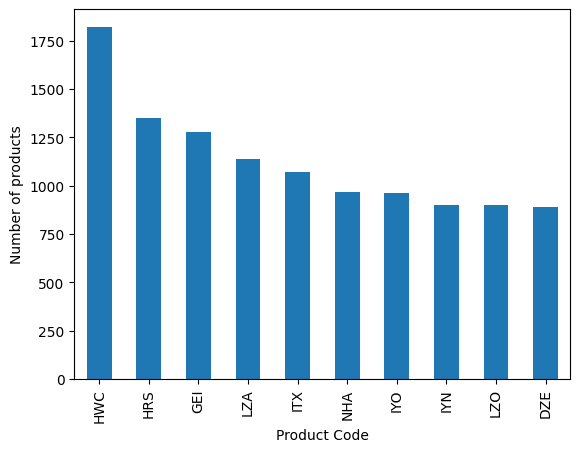

In [44]:
# plot top ten product categories in terms of number of products
product_counts.head(10).plot(kind='bar')
plt.xlabel("Product Code")
plt.ylabel("Number of products");

In [45]:
# Get top ten categories
device_types.loc[product_counts.head(10).index]

,DEVICE_NAME,MEDICAL_SPECIALTY,DEVICE_CLASS
PRODUCT_CODE,,,
HWC,"Screw, Fixation, Bone",OR,2
HRS,"Plate, Fixation, Bone",OR,2
GEI,"Electrosurgical, Cutting & Coagulation & Acces...",SU,2
LZA,Polymer Patient Examination Glove,HO,1
ITX,"Transducer, Ultrasonic, Diagnostic",RA,2
NHA,"Abutment, Implant, Dental, Endosseous",DE,2
IYO,"System, Imaging, Pulsed Echo, Ultrasonic",RA,2
IYN,"System, Imaging, Pulsed Doppler, Ultrasonic",RA,2
LZO,"Prosthesis, Hip, Semi-Constrained, Metal/Ceram...",OR,2


#### Order Distribution

In [46]:
# join product codes onto the currently traded products (no dropping duplicate items)
order_counts = pd.merge(
    reg_imp_cleaned[['KEY_VAL']],
    listing_pcd_cleaned[['KEY_VAL', 'PRODUCT_CODE']],
    on='KEY_VAL'
).PRODUCT_CODE.value_counts()

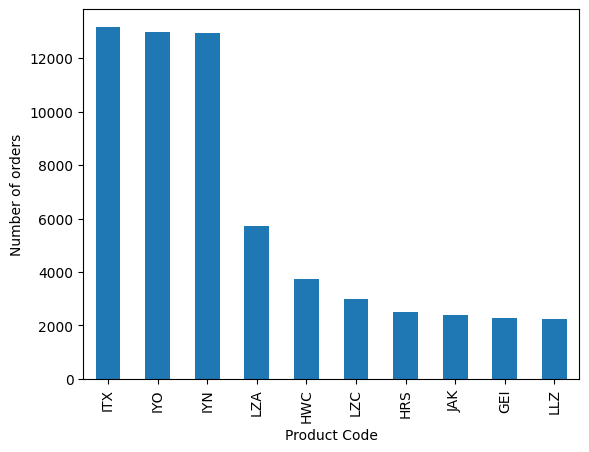

In [47]:
# plot top ten product categories in terms of number of orders
order_counts.head(10).plot(kind='bar')
plt.xlabel("Product Code")
plt.ylabel("Number of orders");

In [48]:
# Get top ten categories
device_types.loc[order_counts.head(10).index]

,DEVICE_NAME,MEDICAL_SPECIALTY,DEVICE_CLASS
PRODUCT_CODE,,,
ITX,"Transducer, Ultrasonic, Diagnostic",RA,2
IYO,"System, Imaging, Pulsed Echo, Ultrasonic",RA,2
IYN,"System, Imaging, Pulsed Doppler, Ultrasonic",RA,2
LZA,Polymer Patient Examination Glove,HO,1
HWC,"Screw, Fixation, Bone",OR,2
LZC,"Medical Glove, Specialty",HO,1
HRS,"Plate, Fixation, Bone",OR,2
JAK,"System, X-Ray, Tomography, Computed",RA,2
GEI,"Electrosurgical, Cutting & Coagulation & Acces...",SU,2


#### Product Growth Over Time

In [49]:
# Extract created date and product code from the listing pcd
code_time = listing_pcd_cleaned.copy()[["CREATED_DATE", "PRODUCT_CODE"]]

In [50]:
# Extract year from date
code_time['YEAR'] = code_time.CREATED_DATE.apply(lambda x: x.year)

In [51]:
# Get the product counts over year
product_count_over_time = code_time.YEAR.value_counts().sort_index().reset_index()

##### Linear fit

In [52]:
# Calculate the correlation between YEAR and count
linear_corr, linear_pval = stats.pearsonr(product_count_over_time.YEAR, 
                                          product_count_over_time['count'])
print(f"Linear corr: {linear_corr:0.3f} p-val: {linear_pval:0.3e}")

Linear corr: 0.857 p-val: 8.095e-15


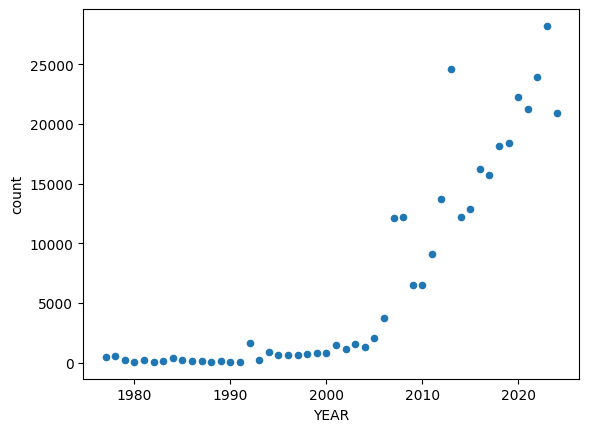

In [53]:
# linear scale scatter plot
product_count_over_time.plot.scatter(x='YEAR', y='count');

In [54]:
# fit YEAR to log count using linear model
lm = LinearRegression()

X = product_count_over_time[['YEAR']]
y = product_count_over_time['count']

lm.fit(X, y)

LinearRegression()

In [55]:
# Evaluate score
lm.score(X, y)

0.7338993094717252

In [56]:
print("Linear model:")
print(f"count = {lm.intercept_:0.3f} + {lm.coef_[0]:0.3f} * YEAR")

Linear model:
count = -1042772.577 + 524.547 * YEAR


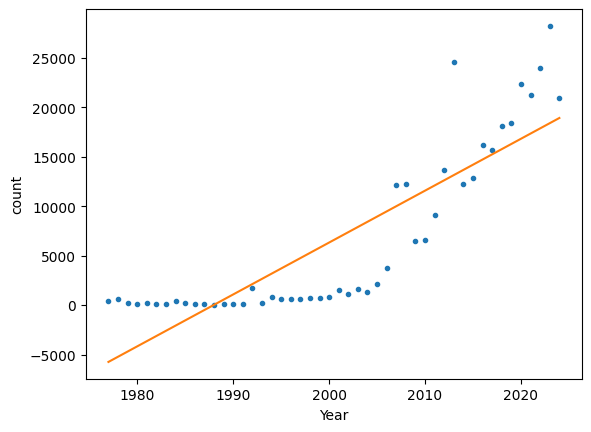

In [57]:
# linear plot
y_hat = lm.predict(X)
plt.plot(X, y, ".", X, y_hat, "-")
plt.xlabel("Year")
plt.ylabel("count");

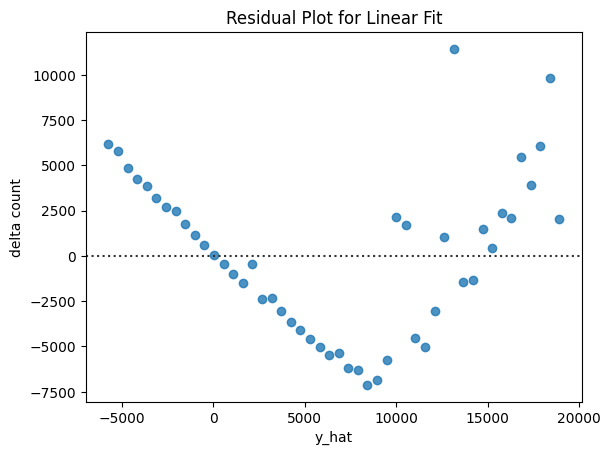

In [58]:
# look at residual (against y_hat)
sns.residplot(x=y_hat, y=y)
plt.xlabel('y_hat')
plt.ylabel('delta count')
plt.title('Residual Plot for Linear Fit');

##### Exponential fit

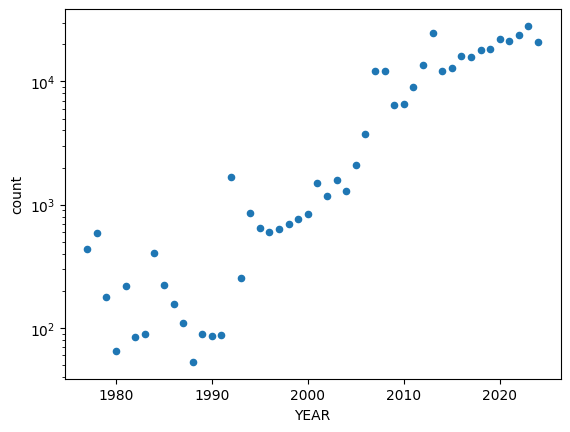

In [59]:
# semilogy plot
product_count_over_time.plot.scatter(x='YEAR', y='count', logy=True);

In [60]:
# log transform corr

log_corr, log_pval = stats.pearsonr(product_count_over_time.YEAR, 
                                    np.log(product_count_over_time['count']))
print(f"Log corr: {log_corr:0.3f} p-val: {log_pval:0.3e}")

Log corr: 0.922 p-val: 1.257e-20


In [61]:
# fit YEAR to log count using linear model
em = LinearRegression()

X = product_count_over_time[['YEAR']]
y = np.log(product_count_over_time['count'])

em.fit(X, y)

LinearRegression()

In [62]:
# Evaluate score
em.score(X, y)

0.8507835521231863

In [63]:
print("Semilogy model:")
print(f"ln(count) = {em.intercept_:0.3f} + {em.coef_[0]:0.3f} * YEAR")

Semilogy model:
ln(count) = -262.406 + 0.135 * YEAR


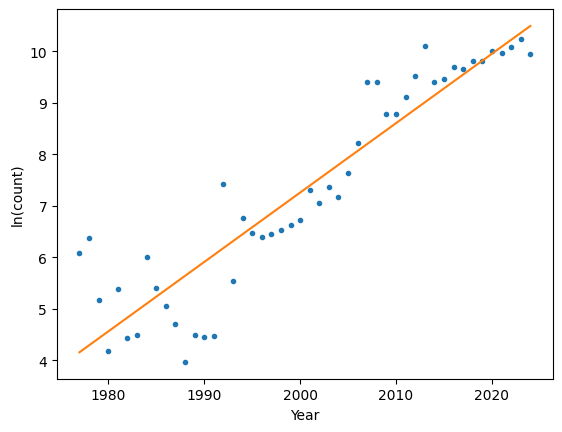

In [64]:
# semilogy plot
y_hat = em.predict(X)
plt.plot(X, y, ".", X, y_hat, "-")
plt.xlabel("Year")
plt.ylabel("ln(count)");

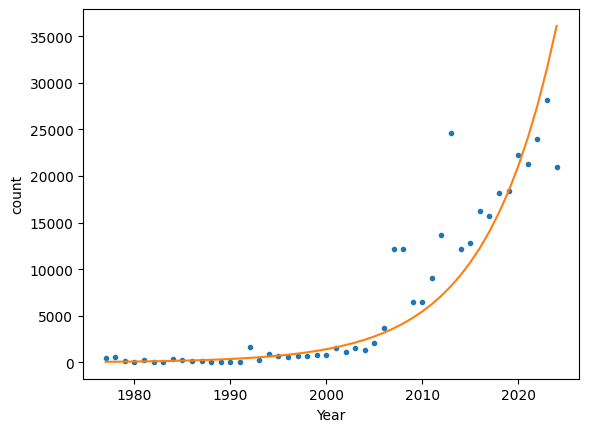

In [65]:
# linear plot with semilogy fit
plt.plot(X, np.exp(y), ".", X, np.exp(y_hat), "-")
plt.xlabel("Year")
plt.ylabel("count");

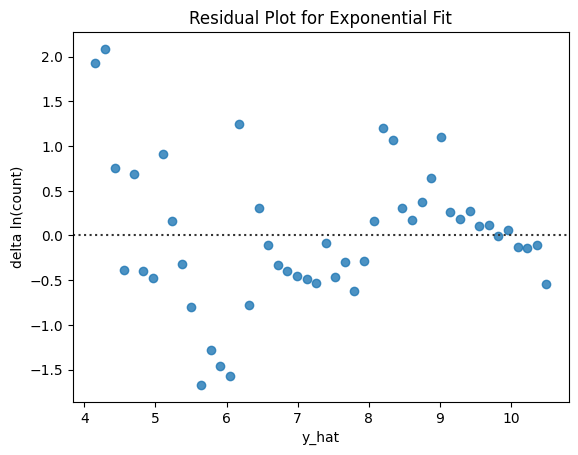

In [66]:
# look at residual (against y_hat)
sns.residplot(x=y_hat, y=y)
plt.xlabel('y_hat')
plt.ylabel('delta ln(count)')
plt.title('Residual Plot for Exponential Fit');

## Scratch

In [67]:
listing_pcd_cleaned

,KEY_VAL,PRODUCT_CODE,CREATED_DATE,OWNER_OPERATOR_NUMBER
0,1468634297,EIC,1977-12-23,9028292
1,1718706204,ECR,1978-03-22,8010155
2,1404748488,EIG,1978-03-22,8010155
3,1058905778,EKB,1978-03-22,8010155
4,1506777348,KBH,1978-03-22,8010155
...,...,...,...,...
316018,1921611742,NNI,2024-04-12,10082121
316019,2049885007,IMD,2024-04-12,10090563
316020,1389810980,LLK,2024-04-12,10090564
316021,1006418876,MAX,2024-04-12,10058316


In [68]:
reg_imp_cleaned

,KEY_VAL,IMPORTER_REG_KEY,ESTABLISHMENT_REG_KEY
0,1651424905,323855,16
1,1673148225,323855,16
2,1103542434,219886,16
3,1522527140,323855,16
4,1037529483,323855,16
...,...,...,...
235142,1232861976,180127,331177
235143,1147260290,180127,331177
235144,2019458915,180127,331177
235145,1769846949,180127,331177


In [69]:
a = pd.merge(
    listing_pcd_cleaned.drop(columns=['OWNER_OPERATOR_NUMBER']),
    reg_imp_cleaned,
    on='KEY_VAL'
)
a

,KEY_VAL,PRODUCT_CODE,CREATED_DATE,IMPORTER_REG_KEY,ESTABLISHMENT_REG_KEY
0,1404748488,EIG,1978-03-22,22838,39893
1,1404748488,EIG,1978-03-22,2339,39893
2,1404748488,EIG,1978-03-22,110332,39893
3,1404748488,EIG,1978-03-22,2534,39893
4,1404748488,EIG,1978-03-22,38731,39893
...,...,...,...,...,...
317811,1178038186,PUP,2024-04-12,328782,216663
317812,1178038186,PUP,2024-04-12,280111,216663
317813,1543839509,FTY,2024-04-12,219201,280228
317814,1006418876,MAX,2024-04-12,99255,221466


In [70]:
registration_cleaned

,REG_KEY,NAME,CITY,STATE_ID,ISO_COUNTRY_CODE
0,7542,DEGUDENT GMBH,HANAU Hesse,NaN,DE
2,6813,PALL NEWQUAY,Newquay Cornwall,NaN,GB
3,6388,ZEUS SCIENTIFIC,BRANCHBURG,NJ,US
4,8526,"Pascal International, Inc.",Bellevue,WA,US
6,9037,SEPTODONT HEALTHCARE INDIA PRIVATE LTD.,"VILLAGE-NAVADE, TALUKA-PANVEL Maharashtra",NaN,IN
...,...,...,...,...,...
46484,330902,"ZEUS GEAR, LLC",Reno,NV,US
46486,331124,BSD PRODUCT DESIGN INC.,Taipei City,NaN,TW
46487,330364,Solventum US LLC,Brookings,SD,US
46488,330554,"Vernon Area Rehabilitation Center, Inc. - Raci...",Racine,WI,US


In [71]:
b = pd.merge(
    a,
    registration_cleaned[['REG_KEY', 'ISO_COUNTRY_CODE']],
    left_on = 'IMPORTER_REG_KEY',
    right_on = 'REG_KEY'
).rename(columns={'ISO_COUNTRY_CODE': 'IMPORTER_COUNTRY'}).drop(columns=['REG_KEY'])
b

,KEY_VAL,PRODUCT_CODE,CREATED_DATE,IMPORTER_REG_KEY,ESTABLISHMENT_REG_KEY,IMPORTER_COUNTRY
0,1404748488,EIG,1978-03-22,2339,39893,US
1,1404748488,EIG,1978-03-22,110332,39893,US
2,1404748488,EIG,1978-03-22,38731,39893,US
3,1168626079,FZY,1978-03-22,45964,39893,US
4,1254713340,GAI,1978-03-22,110332,39893,US
...,...,...,...,...,...,...
265996,1178038186,PUP,2024-04-12,328782,216663,US
265997,1178038186,PUP,2024-04-12,280111,216663,US
265998,1543839509,FTY,2024-04-12,219201,280228,IL
265999,1006418876,MAX,2024-04-12,99255,221466,US


In [72]:
c = pd.merge(
    b,
    registration_cleaned[['REG_KEY', 'ISO_COUNTRY_CODE']],
    left_on = 'ESTABLISHMENT_REG_KEY',
    right_on = 'REG_KEY'
).rename(columns={'ISO_COUNTRY_CODE': 'ESTABLISHMENT_COUNTRY'}).drop(columns=['REG_KEY'])
c

,KEY_VAL,PRODUCT_CODE,CREATED_DATE,IMPORTER_REG_KEY,ESTABLISHMENT_REG_KEY,IMPORTER_COUNTRY,ESTABLISHMENT_COUNTRY
0,1404748488,EIG,1978-03-22,2339,39893,US,DE
1,1404748488,EIG,1978-03-22,110332,39893,US,DE
2,1404748488,EIG,1978-03-22,38731,39893,US,DE
3,1168626079,FZY,1978-03-22,45964,39893,US,DE
4,1254713340,GAI,1978-03-22,110332,39893,US,DE
...,...,...,...,...,...,...,...
263928,1178038186,PUP,2024-04-12,328782,216663,US,CA
263929,1178038186,PUP,2024-04-12,280111,216663,US,CA
263930,1543839509,FTY,2024-04-12,219201,280228,IL,IL
263931,1006418876,MAX,2024-04-12,99255,221466,US,CN


In [73]:
foiclass_cleaned

,PRODUCT_CODE,DEVICE_NAME,MEDICAL_SPECIALTY,DEVICE_CLASS
0,BRW,"Protector, Dental",AN,1
1,BRX,"Stool, Anesthesia",AN,1
2,BRY,"Cabinet, Table And Tray, Anesthesia",AN,1
3,BSE,"Analyzer, Gas, Helium, Gaseous-Phase",AN,2
4,BSF,"Absorber, Carbon-Dioxide",AN,1
...,...,...,...,...
6938,RIM,"Laser Marker, Cutter, Or Engraver, Tabletop, C...",NaN,N
6939,RIN,Laser Illuminated Lighting Instrument,NaN,N
6940,RIO,Led Toys And Entertainment Products,NaN,N
6941,RIP,Led Diodes Sold As Components To Be Installed ...,NaN,N


In [74]:
d = pd.merge(
    foiclass_cleaned.drop(columns='DEVICE_NAME'),
    c,
    on='PRODUCT_CODE'
)
d = d.sort_values('CREATED_DATE')

d['MEDICAL_SPECIALTY'] = d['MEDICAL_SPECIALTY'].fillna('NA')

In [75]:
# get speciality names
name = [
    'Anesthesiology',
    'Cardiovascular',
    'Clinical Chemistry',
    'Dental',
    'Ear, Nose, & Throat',
    'Gastroenterology',
    'General Hospital',
    'Hematology',
    'Immunology',
    'Microbiology',
    'Neurology',
    'Obstetrics/Gynecology',
    'Ophthalmic',
    'Orthopedic',
    'Pathology',
    'Physical Medicine',
    'Radiology',
    'General & Plastic Surgery',
    'Clinical Toxicology',
    'NOT SPECIALIZED'
]

code = [
    'AN',
    'CV',
    'CH',
    'DE',
    'EN',
    'GU',
    'HO',
    'HE',
    'IM',
    'MI',
    'NE',
    'OB',
    'OP',
    'OR',
    'PA',
    'PM',
    'RA',
    'SU',
    'TX',
    'NA'
]

ms_code_to_name = pd.DataFrame({'MEDICAL_SPECIALTY':code, 'SPECIALTY_NAME':name})

In [76]:
ms_code_to_name

,MEDICAL_SPECIALTY,SPECIALTY_NAME
0,AN,Anesthesiology
1,CV,Cardiovascular
2,CH,Clinical Chemistry
3,DE,Dental
4,EN,"Ear, Nose, & Throat"
5,GU,Gastroenterology
6,HO,General Hospital
7,HE,Hematology
8,IM,Immunology
9,MI,Microbiology


In [77]:
# export important dfs as a csv
d.to_csv('./data/MedDev.csv', index=False)
foiclass_cleaned[['PRODUCT_CODE', 'DEVICE_NAME']].to_csv('./data/ProductName.csv', index=False)
ms_code_to_name.to_csv('./data/SpecialtyName.csv', index=False)